# Data cleaning, integration and quick EDA

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely import geometry
import dill
import pickle

# Show all columns
pd.set_option('display.max_columns', None)

# Plot style
plt.rcParams['font.size'] = 12

# setup data folder
data_path = '/home/data/'
# !ls $data_path

In [2]:
# Add a background map to the plot
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    #xmin, xmax, ymin, ymax = ax.axis()
    xmin, xmax, ymin, ymax = -7925000, -7895000, 5195000, 5220000
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
# Convert coordinates of a geopandas and plot on a bg map
def plot_on_map(geodf, col='k'):
    ax = geodf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor=col)
    add_basemap(ax, zoom=12)
    return ax
    
# Convert to WGS 84 (Ellipsoidal 2D lat/long in degree)
# See https://epsg.io/4326
def to_lat_long(geodf):
    return geodf.to_crs({'init': 'epsg:4326'})

# Convert to WGS 84 Pseudo-Mercator (cartesian 2D X/Y in meter) used in Google Maps, OpenStreetMap, ArcGIS, ESRI, ...
# See https://epsg.io/3857
def to_x_y(geodf):
    return geodf.to_crs({'init': 'epsg:3857'})

# Convert types for GeoJSON file writing with fiona
upcast_dispatch = {geometry.Point: geometry.MultiPoint, 
                   geometry.LineString: geometry.MultiLineString,
                   geometry.Polygon: geometry.MultiPolygon}
def maybe_cast_to_multigeometry(geom):
    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
    return caster([geom])

# Find the closest street segment to a point
def find_nearest_seg(point, lines, thresh=20, return_dist=False):
    # Found a threshold of 20m based on looking at histogram:
    # geocrash1.geometry.apply(lambda p,l: l.distance(p).min(), args=(bostonsegs,)).hist()
    dist = lines.distance(point)
    id = dist.idxmin()
    if return_dist:
        return id if dist[id] < thresh else np.nan,dist
    else:
        return id if dist[id] < thresh else np.nan


OBJECTID  SEGMENT_ID  STREET_ID PRE_DIR        ST_NAME ST_TYPE SUF_DIR  \
0             1           1          2                      A      ST           
1             2           2          2                      A      ST           
2             3           3          2                      A      ST           
3             4           4          2                      A      ST           
4             5           5          2                      A      ST           
5             6           6          2                      A      ST           
6             7           7          2                      A      ST           
7             8          10          2                      A      ST           
8             9          11          4             Abbotsford      ST           
9            10          12          4             Abbotsford      ST           
10           11          13          3                  Abbot      ST           
11           12          14          5                   Abby      RD           
12           13          15          7                 Acacia      RD           
13           14          16          9                Academy      CT           
14           15          17         11           Academy Hill      RD           
15           16          18         11           Academy Hill      RD           
16           17          19         11           Academy Hill      RD           
17           18          20         11           Academy Hill      RD           
18           19          22          8                Academy      RD           
19           20          23          8                Academy      RD           
20           21          24          8                Academy      RD           
21           22          25         10                Academy     TER           
22           23          26         12                 Acadia      ST           
23           24          27         13                 Achorn     CIR           
24           25          28         14                 Ackley      PL           
25           26          29         15                  Acorn      ST           
26           27          30         16                  Acton      ST           
27           28          31         23                  Adams      PL           
28           29          32         24                  Adams      ST           
29           30          34         24                  Adams      ST           
...         ...         ...        ...     ...            ...     ...     ...   
18976     18977        3153       1620               Franklin      ST           
18977     18978       17907       2946            New England     AVE           
18978     18979        5644       2946            New England     AVE           
18979     18980        5645       2946            New England     AVE           
18980     18981        2371       4826                  Dewey     TER           
18981     18982        9520       1214                  Dewey      ST           
18982     18983        2368       1214                  Dewey      ST           
18983     18984       26936       5561                 Autumn      LN           
18984     18985       26935        478           Boston Wharf      RD           
18985     18986       15645        478           Boston Wharf      RD           
18986     18987       26937       5561                 Autumn      LN           
18987     18988       22888       4848       E        Service      RD           
18988     18989       27047       4848       E        Service      RD           
18989     18990       23146       1151          David G Mugar     WAY           
18990     18991       26871       5550               Thornton      RD           
18991     18992       27048       1335              Edgewater      DR           
18992     18993       27049       3009               Northern     AVE           
18993     18994        5742       5106

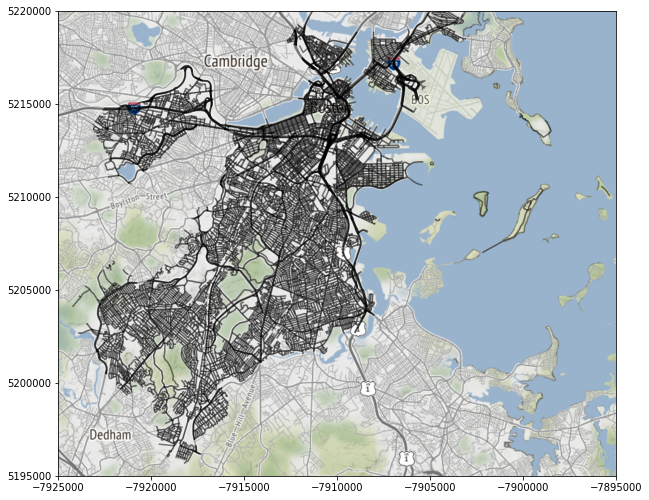

In [3]:
# Load Boston street segments
bostonsegs = gpd.read_file(data_path + 'Boston_Street_Segments.geojson')

# Notes:
# - not using that dataset anymore
# - this does not seem to contain bike paths like the esplanade
feature_sel = [
    'OBJECTID',   # Unique ID
    'SEGMENT_ID', # Unique ID for street segment identification
    'STREET_ID',  # Unique ID for street name
    'PRE_DIR',
    'ST_NAME',
    'ST_TYPE',
    'SUF_DIR',
    'CFCC',       # US Census Bureau Feature Class Code, road classification
    'SPEEDLIMIT', # Speed limit
    'ONEWAY',
    'FT_COST',    # Travel time in minutes, From-To direction
    'SHAPElen',   # Length of the street segment in feet
    'geometry'
]
bostonsegs = bostonsegs[feature_sel]
plot_on_map(bostonsegs)
bostonsegs

OBJECTID Route_ID  Rd_Seg_ID              St_Name             Facility  \
0           856    B0240        NaN                 None  Bicycle/ Pedestrian   
1           858    B0240        NaN                 None  Bicycle/ Pedestrian   
2           860    B0240        NaN                 None  Bicycle/ Pedestrian   
3           882    B0246        NaN                 None  Bicycle/ Pedestrian   
4           883    B0247        NaN                 None  Bicycle/ Pedestrian   
5           884    B0247        NaN                 None  Bicycle/ Pedestrian   
6           885    B0247        NaN                 None  Bicycle/ Pedestrian   
7           886    B0248        NaN                 None  Bicycle/ Pedestrian   
8           887    B0248        NaN                 None  Bicycle/ Pedestrian   
9           888    B0248        NaN                 None  Bicycle/ Pedestrian   
10          890    B0248        NaN                 None  Bicycle/ Pedestrian   
11          891    B0249        NaN                 None  Bicycle/ Pedestrian   
12         1019    B0283        NaN                 None  Bicycle/ Pedestrian   
13         1020    B0283        NaN                 None  Bicycle/ Pedestrian   
14         1021    B0283        NaN                 None  Bicycle/ Pedestrian   
15         1022    B0283        NaN                 None  Bicycle/ Pedestrian   
16         1023    B0283        NaN                 None  Bicycle/ Pedestrian   
17         1024    B0283        NaN                 None  Bicycle/ Pedestrian   
18         1025    B0283        NaN                 None  Bicycle/ Pedestrian   
19         1027    B0283        NaN                 None  Bicycle/ Pedestrian   
20         1028    B0283        NaN                 None  Bicycle/ Pedestrian   
21         1029    B0283        NaN                 None  Bicycle/ Pedestrian   
22         1030    B0283        NaN                 None  Bicycle/ Pedestrian   
23         1031    B0283        NaN                 None  Bicycle/ Pedestrian   
24         1032    B0283        NaN                 None  Bicycle/ Pedestrian   
25         1033    B0283        NaN                 None  Bicycle/ Pedestrian   
26         1035    B0283        NaN                 None  Bicycle/ Pedestrian   
27         1037    B0283        NaN                 None  Bicycle/ Pedestrian   
28         1039    B0283        NaN                 None  Bicycle/ Pedestrian   
29         1041    B0283        NaN                 None  Bicycle/ Pedestrian   
...         ...      ...        ...                  ...                  ...   
29136    621269  US20 WB   477153.0  NORTH BEACON STREET     Mainline roadway   
29137    621270  US20 WB   477153.0  NORTH BEACON STREET     Mainline roadway   
29138    621271  US20 WB   477153.0  NORTH BEACON STREET     Mainline roadway   
29139    621272  US20 WB    62346.0  NORTH BEACON STREET     Mainline roadway   
29140    621273  US20 WB    62381.0  NORTH BEACON STREET     Mainline roadway   
29141    621274  US20 WB    62381.0  NORTH BEACON STREET     Mainline roadway   
29142    621275  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29143    621276  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29144    621277  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29145    621278  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29146    621279  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29147    621280  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29148    621281  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29149    621282  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29150    621283  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29151    621284  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29152    621285  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29153    621286  US20 WB    62448.0  N

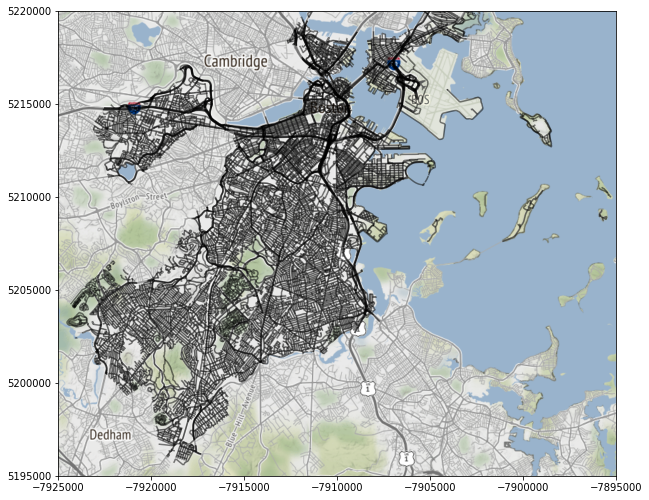

In [4]:
# Load all the MA roads restricted to the Boston area
rebuild = 0
if rebuild:
    masegs = gpd.read_file(data_path + 'Road_Inventory_2017.geojson', bbox=bostonsegs.envelope) # loading around the boston area
    masegs = masegs[masegs.City == 'Boston']
    masegs.index = range(len(masegs.index))
    masegs.geometry = masegs.geometry.apply(maybe_cast_to_multigeometry)
    masegs.to_file(data_path + 'Road_Inventory_2017_Bostonsubset.geojson', driver='GeoJSON')
else:
    masegs = gpd.read_file(data_path + 'Road_Inventory_2017_Bostonsubset.geojson')

# Notes: 
# - segments from the bike paths like the espalanade have no names and Rd_Seg_ID 
feature_sel = [
    'OBJECTID',      # OBJECTID [id]
    'Route_ID',      # Route ID [id]
    'Rd_Seg_ID',     # Road Segment ID [id]
    'St_Name',       # Street Name [str]
    'Facility',      # Facility Type [cat]
    'F_F_Class',     # Federal Functional Class [cat]
    'Num_Lanes',     # Number of Travel Lanes [cont]
    'Lt_Sidewlk',    # Left Sidewalk Width [cont]
    'Rt_Sidewlk',    # Right Sidewalk Width [cont]
    'Operation',     # Street Operation [cat]
    'Speed_Lim',     # Speed limit [cont] (has less null than Speed)
    'Struct_Cnd',    # Structural Condition [cat]
    'AADT',          # AADT [cont] (note: estimated for different years, see AADT_Year)
    'Length',        # Length [cont]
    'ShapeSTLength', # Shape.STLength() [cont]
    'geometry'
]
masegs = masegs[feature_sel]

# Fix some missing/inconsistent values
# Notes:
# - there are still some inconsistencies in the street information after fixing, for example see:
#   masegs[masegs.St_Name == 'BAY STATE ROAD'] # Not all the segments of the street are labeled correctly
# - one solution would be to filter missing/wrong values by street, assuming same values for a given street name St_Name
# - another solution would be to use better data like Open Street Map information too
masegs['St_Name'][masegs.St_Name == ''] = None # changing empty str to None
masegs['Facility'].fillna('Bicycle/ Pedestrian', inplace=True) # based on the map & value, those segments are bike/ped paths
masegs.loc[masegs.Facility == 'Bicycle/ Pedestrian', 'AADT'] = 0
masegs['F_F_Class'].fillna('Local', inplace=True)
masegs.loc[(masegs['Facility'] == 'Bicycle/ Pedestrian') & (masegs['Num_Lanes'] > 0), 'Num_Lanes'] = 0 # bike/ped paths don't lanes
masegs['Num_Lanes'].fillna(0, inplace=True) # based on the map, those segments are mostly bike/ped paths, so 0 lanes
masegs['Lt_Sidewlk'].fillna(0, inplace=True) # most missing values are for bike/ped paths so setting to 0
masegs['Rt_Sidewlk'].fillna(0, inplace=True) # most missing values are for bike/ped paths so setting to 0
masegs.loc[masegs.Operation == '0', 'Operation'] = 'No traffic' # creating a category for bike/ped paths
masegs['Operation'].fillna('No traffic', inplace=True)
masegs.loc[masegs.Speed_Lim == 99, 'Speed_Lim'] = np.nan # speed of 99 is wrong, replacing with nan
masegs.loc[masegs.Speed_Lim == 0, 'Speed_Lim'] = np.nan # speed of 0 is wrong, replacing with nan
masegs['Speed_Lim'] = masegs.groupby('F_F_Class')['Speed_Lim'].apply(lambda x: x.fillna(x.mean())) # using average for filling nan
masegs.loc[masegs.Facility == 'Bicycle/ Pedestrian', 'Speed_Lim'] = 30 # picking a reasonable value for bike/ped paths
masegs['Struct_Cnd'].fillna('Fair', inplace=True) # Fair is the most common (even when looking across F_F_Class)
masegs['AADT'] = masegs.groupby('F_F_Class')['AADT'].apply(lambda x: x.fillna(x.mean())) # filling aadt using within class median estimation


masegs = to_x_y(masegs)
bostonsegs = to_x_y(bostonsegs) # convert only now because used in bbox above
plot_on_map(masegs)
masegs

BL            1118
SLM            830
SUP            193
CL             150
BFBL            73
SUC             53
BSBL            40
CT1-2           35
CTBL            25
PSL             18
SRd             16
                15
SUB             11
CT2-1           10
PBFBL            7
CT1-1            5
CFBL             2
SLM\r\n          2
PS               2
BFCL             2
SLM\r\nSLM       1
Name: ExisFacil, dtype: int64
exclusive    1350
shared        935
protected     323
Name: ExisFacil, dtype: int64


FID  OBJECTID                           STREET_NAM  Rd_Seg_ID  \
0     1001      8777                        Warren Street    47142.0   
1     1002      8785                     Blue Hill Avenue    51753.0   
2     1003      8792                     Blue Hill Avenue    62823.0   
3     1004      8794                     Blue Hill Avenue    49663.0   
4     1005      8803                        Morton Street    56908.0   
5     1006      8804              American Legion Highway    62361.0   
6     1007      8810                        Walnut Avenue    53082.0   
7     1008      8811                        Walnut Avenue    47102.0   
8     1009      8834                      Thornton Street    58322.0   
9     1010      8848                       Tremont Street    57809.0   
10    1011      8854                    Huntington Avenue    62616.0   
11    1012      8855                          Museum Road    53812.0   
12    1013      8856                       Ruggles Street    63055.0   
13    1014      8857                          Forsyth Way    54249.0   
14    1015      8863                  Commonwealth Avenue    62246.0   
15    1016      8864                     Brookline Avenue   457321.0   
16    1017      8883                     Blue Hill Avenue    51242.0   
17    1018      8885                     Blue Hill Avenue    62239.0   
18    1019      8892                     Blue Hill Avenue    62188.0   
19    1020      8893                     Blue Hill Avenue    62191.0   
20    1021      8899                     Blue Hill Avenue    62193.0   
21    1022      8900                     Blue Hill Avenue    62194.0   
22    1023      8902                     Blue Hill Avenue    48566.0   
23    1024      8903                     Blue Hill Avenue    51113.0   
24    1025      8910                     Blue Hill Avenue    48054.0   
25    1026      8911                        Talbot Avenue    56910.0   
26    1027      8913                     Blue Hill Avenue    62273.0   
27    1028      8921                      Humboldt Avenue    46932.0   
28    1029      8922                      Humboldt Avenue    46838.0   
29    1030      8923                      Humboldt Avenue    46742.0   
...    ...       ...                                  ...        ...   
2578  2579     18277                       Harvard Avenue    58716.0   
2579  2580     19025                        Columbia Road    62465.0   
2580  2581     20867  Emerald Necklace Trail/Sears Rotary        NaN   
2581  2582     18293                 North Harvard Street    44517.0   
2582  2583     19027                        Columbia Road    57765.0   
2583  2584     20869               Emerald Necklace Trail        NaN   
2584  2585     18295                     Cambridge Street    62649.0   
2585  2586     19029                        Columbia Road    62466.0   
2586  2587     20870               Emerald Necklace Trail        NaN   
2587  2588     19031                     Blue Hill Avenue    52234.0   
2588  2589     18297                     Cambridge Street    56096.0   
2589  2590     19034                        Warren Street    46957.0   
2590  2591     18300                 North Harvard Street    57535.0   
2591  2592     20871                                             NaN   
2592  2593     19035                        Warren Street    62636.0   
2593  2594     18307                 North Harvard Street    57388.0   
2594  2595     20873               Emerald Necklace Trail        NaN   
2595  2596     19037                        Warren Street    56018.0   
2596  2597     18343                      Cummins Highway    55402.0   
2597  2598     20877                                             NaN   
2598  2599     19051                        Warren Street    62865.0   
2599  2600     20881                    Boston Harborwalk        NaN   
2600  2601     19058                    Washington Street    46095.0   
2601  2602     20884               Emerald Neck

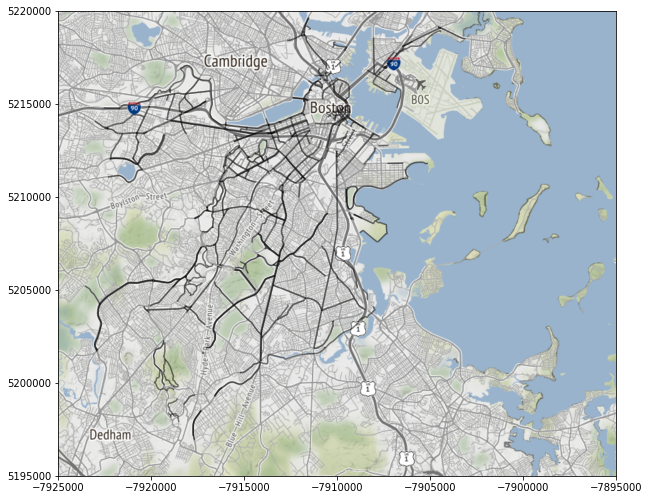

In [5]:
# Load the Boston bike lane network
# Notes:
# - LTS is level of traffic stress range [0,4]
geolanes = gpd.read_file(data_path + 'Existing_Bike_Network.geojson')

feature_sel = [
    'FID',
    'OBJECTID',
    'STREET_NAM',
    'ROADINVENT',
    'FUNCTIONAL', # similar to F_F_Class
    'InstallDat',
    'ExisFacil',
    'Road',
    'Divided',
    'TravelLane',
    'OneWay',
    'LTS',
    'Shape_Leng',
    'Shape__Length',
    'geometry'
]
geolanes = geolanes[feature_sel]

geolanes = to_x_y(geolanes)
# geolanes = geolanes[geolanes.InstallDat != '0'] # drop lanes without construction date
# geolanes.index = range(len(geolanes.index))

# Simplify the bike lane types into 'exclusive', 'protected', 'shared'
print(geolanes['ExisFacil'].value_counts())
simplified_bl_cat = {
    'BL':'exclusive',
    'SLM':'shared',
    'SUP':'protected',
    'CL':'exclusive',
    'BFBL':'exclusive',
    'SUC':'protected',
    'BSBL':'shared',
    'CT1-2':'protected',
    'CTBL':'protected',
    'PSL':'shared',
    'SRd':'shared',
    ' ':'shared',
    'SUB':'shared',
    'CT2-1':'protected',
    'PBFBL':'exclusive',
    'CT1-1':'protected',
    'PS':'shared',
    'BFCL':'exclusive',
    'CFBL':'protected',
    'SLM\r\n':'shared',
    'SLM\r\nSLM':'shared'
}
geolanes['ExisFacil'] = geolanes['ExisFacil'].map(simplified_bl_cat).astype('category')
print(geolanes['ExisFacil'].value_counts())
geolanes['ROADINVENT'] = geolanes['ROADINVENT'].apply(lambda f: int(f/100))
geolanes.loc[geolanes.ROADINVENT == 0, 'ROADINVENT'] = np.nan
geolanes.rename(columns={'ROADINVENT':'Rd_Seg_ID'}, inplace=True)


plot_on_map(geolanes)
geolanes

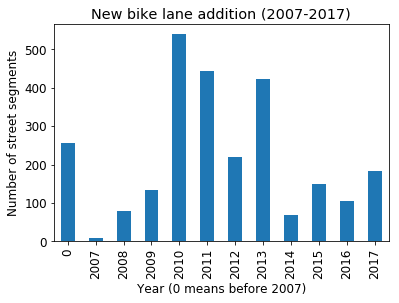

In [38]:
# Summary plot showing bike lane creation
f = plt.figure()
geolanes['InstallDat'].value_counts().sort_index().plot(kind='bar')
plt.title('New bike lane addition (2007-2017)')
plt.xlabel('Year (0 means before 2007)')
plt.ylabel('Number of street segments')
f.savefig("fig/hist_bike_lane_addition.png", bbox_inches='tight')

DATE  YEAR   DAY_WEEK  TIME  ISINTERSEC  \
0     2009-01-09  2009     Friday    14         1.0   
1     2009-01-23  2009     Friday    16         1.0   
2     2009-01-25  2009     Sunday    12         0.0   
3     2009-02-05  2009   Thursday     5         1.0   
4     2009-02-08  2009     Sunday     8         0.0   
5     2009-02-09  2009     Monday    23         0.0   
6     2009-02-13  2009     Friday    13         0.0   
7     2009-02-13  2009     Friday    17         1.0   
8     2009-02-19  2009   Thursday    20         0.0   
9     2009-02-21  2009   Saturday    13         1.0   
10    2009-02-25  2009  Wednesday    12         0.0   
11    2009-03-01  2009   Saturday    23         0.0   
12    2009-03-01  2009     Sunday    16         1.0   
13    2009-03-05  2009   Thursday    10         0.0   
14    2009-03-05  2009   Thursday    15         0.0   
15    2009-03-12  2009   Thursday    17         1.0   
16    2009-03-15  2009     Sunday    15         1.0   
17    2009-03-16  2009     Monday    19         1.0   
18    2009-03-18  2009  Wednesday    19         1.0   
19    2009-03-22  2009     Sunday    14         1.0   
20    2009-03-22  2009     Sunday    16         1.0   
21    2009-03-22  2009     Sunday    17         0.0   
22    2009-03-22  2009     Sunday    19         1.0   
23    2009-03-23  2009     Monday    12         0.0   
24    2009-03-24  2009    Tuesday    13         0.0   
25    2009-03-24  2009    Tuesday    17         0.0   
26    2009-03-25  2009  Wednesday    17         1.0   
27    2009-03-27  2009     Friday     8         1.0   
28    2009-03-27  2009     Friday    10         1.0   
29    2009-03-28  2009   Saturday    20         1.0   
...          ...   ...        ...   ...         ...   
1699  2012-11-16  2012     Friday    15         0.0   
1700  2012-11-17  2012     Friday     0         0.0   
1701  2012-11-18  2012     Sunday    12         1.0   
1702  2012-11-18  2012     Sunday    16         0.0   
1703  2012-11-15  2012   Thursday    18         0.0   
1704  2012-11-20  2012    Tuesday     8         0.0   
1705  2012-11-20  2012    Tuesday     9         0.0   
1706  2012-11-20  2012    Tuesday    18         1.0   
1707  2012-11-21  2012  Wednesday     8         1.0   
1708  2012-11-21  2012  Wednesday     9         0.0   
1709  2012-11-23  2012     Friday    14         1.0   
1710  2012-11-23  2012     Friday    18         1.0   
1711  2012-11-24  2012   Saturday    20         0.0   
1712  2012-11-25  2012     Sunday    19         1.0   
1713  2012-11-26  2012     Monday    20         1.0   
1714  2012-11-29  2012   Thursday     9         1.0   
1715  2012-11-29  2012   Thursday    15         0.0   
1716  2012-12-03  2012     Monday    13         0.0   
1717  2012-12-03  2012     Monday    19         0.0   
1718  2012-12-04  2012    Tuesday     8         1.0   
1719  2012-12-04  2012    Tuesday    11         0.0   
1720  2012-12-05  2012  Wednesday    20         1.0   
1721  2012-12-06  2012   Thursday     8         0.0   
1722  2012-12-06  2012   Thursday     8         1.0   
1723  2012-12-05  2012  Wednesday    18         1.0   
1724  2012-12-06  2012   Thursday    11         0.0   
1725  2012-12-13  2012   Thursday    18         1.0   
1726  2012-12-18  2012    Tuesday     8         1.0   
1727  2012-11-12  2012     Monday    23         1.0   
1728  2012-12-22  2012   Saturday    16         0.0   

                                          geometry  
0     POINT (-7917183.510539606 5213806.049335828)  
1      POINT (-7918979.09338661 5214087.732639168)  
2     POINT (-7913442.156280413 5210339.438534557)  
3     POINT (-7906207.412175795 5218329.055240225)  
4      POINT (-7910665.38230236 5213196.338006518)  
5     POINT (-7917670.212299837 5203970.306442088)  
6     POINT (-7910660.174235678 5214412.612292374)  
7     POINT (-7913603.476843713 5213557.512253662)  
8     POINT (-7912622.430486054 5213041.146984699)  
9     POINT (-7912297.699731556 5213562.030957619)  
10    POINT (-7912

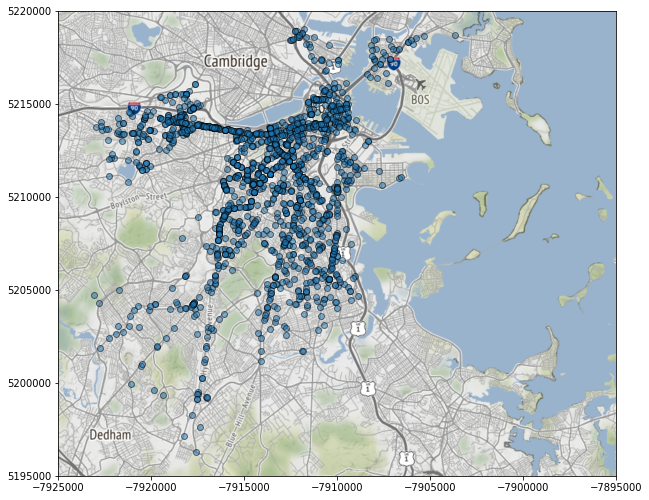

In [25]:
# Load the first crash dataset (2009-2012)
geocrash1 = gpd.read_file(data_path + 'dataverse_files/Bike Collisions/')

feature_sel = [
    'ID',
    'YEAR',
    'DATE',
    'DAY_WEEK',
    'TIME',
    'ISINTERSEC',
    'geometry'
]
geocrash1 = geocrash1[feature_sel]

# fixes and cleaning
crash1 = pd.read_excel(data_path + 'dataverse_files/Final Bike Collision Database.xlsx')
crash1 = crash1[['ID', 'TIME']]
geocrash1 = pd.merge(geocrash1.drop('TIME', axis=1), crash1, on='ID')
geocrash1.drop(geocrash1.index[-2:], inplace=True) # bad last row
#geocrash1.index = range(len(geocrash1.index))
geocrash1['DATE'] = pd.to_datetime(geocrash1['DATE']).dt.date
geocrash1['YEAR'] = geocrash1['YEAR'].astype('int')
geocrash1['TIME'] = geocrash1['TIME'].astype('str').apply(lambda s: pd.datetime.strptime(s.split('.')[0], '%H:%M:%S'))
geocrash1['TIME'] = geocrash1['TIME'].dt.hour
geocrash1 = geocrash1[['DATE', 'YEAR', 'DAY_WEEK', 'TIME', 'ISINTERSEC', 'geometry']]

geocrash1 = to_x_y(geocrash1)
plot_on_map(geocrash1)
geocrash1

DATE  YEAR   DAY_WEEK  TIME  ISINTERSEC  \
0     2015-01-01  2015   Thursday    18           1   
1     2015-01-02  2015     Friday    22           0   
2     2015-01-05  2015     Monday     8           0   
3     2015-01-05  2015     Monday    12           0   
4     2015-01-12  2015     Monday    13           1   
5     2015-01-12  2015     Monday    16           1   
6     2015-01-15  2015   Thursday    20           1   
7     2015-01-20  2015    Tuesday     6           1   
8     2015-01-20  2015    Tuesday     8           0   
9     2015-01-22  2015   Thursday     0           0   
10    2015-01-22  2015   Thursday     8           1   
11    2015-01-22  2015   Thursday    18           1   
12    2015-01-23  2015     Friday    23           1   
13    2015-01-24  2015   Saturday     2           1   
14    2015-02-26  2015   Thursday     9           1   
15    2015-02-26  2015   Thursday    18           1   
16    2015-03-09  2015     Monday    20           1   
17    2015-03-11  2015  Wednesday    12           1   
18    2015-03-18  2015  Wednesday     8           0   
19    2015-03-21  2015   Saturday    17           0   
20    2015-03-25  2015  Wednesday    16           1   
21    2015-03-27  2015     Friday    10           1   
22    2015-03-27  2015     Friday    14           0   
23    2015-03-27  2015     Friday    19           0   
24    2015-03-30  2015     Monday    14           1   
25    2015-03-31  2015    Tuesday     8           1   
26    2015-03-31  2015    Tuesday    21           1   
27    2015-04-04  2015   Saturday    11           1   
28    2015-04-04  2015   Saturday    20           1   
29    2015-04-04  2015   Saturday    21           1   
...          ...   ...        ...   ...         ...   
1711  2018-11-19  2018     Monday    19           1   
1712  2018-11-19  2018     Monday    22           0   
1713  2018-11-26  2018     Monday     6           1   
1714  2018-11-28  2018  Wednesday    20           1   
1715  2018-11-29  2018   Thursday    18           0   
1716  2018-11-30  2018     Friday     6           0   
1717  2018-11-30  2018     Friday     7           1   
1718  2018-11-30  2018     Friday    11           1   
1719  2018-11-30  2018     Friday    17           0   
1720  2018-12-01  2018   Saturday    11           0   
1721  2018-12-03  2018     Monday     6           1   
1722  2018-12-03  2018     Monday    17           0   
1723  2018-12-03  2018     Monday    18           1   
1724  2018-12-04  2018    Tuesday     8           1   
1725  2018-12-04  2018    Tuesday    21           0   
1726  2018-12-07  2018     Friday     7           1   
1727  2018-12-07  2018     Friday     8           0   
1728  2018-12-10  2018     Monday    16           1   
1729  2018-12-11  2018    Tuesday    19           0   
1730  2018-12-12  2018  Wednesday    19           1   
1731  2018-12-13  2018   Thursday    16           1   
1732  2018-12-14  2018     Friday    22           1   
1733  2018-12-15  2018   Saturday    17           0   
1734  2018-12-16  2018     Sunday    20           1   
1735  2018-12-16  2018     Sunday    23           1   
1736  2018-12-17  2018     Monday    16           0   
1737  2018-12-18  2018    Tuesday    18           1   
1738  2018-12-20  2018   Thursday     9           1   
1739  2018-12-24  2018     Monday    17           0   
1740  2018-12-26  2018  Wednesday    16           0   

                                          geometry  
0     POINT (-7911383.039276199 5206839.121173365)  
1     POINT (-7913807.856678441 5209112.006565886)  
2      POINT (-7914572.476260683 5210338.38507072)  
3     POINT (-7910305.593172246 5206294.788029618)  
4     POINT (-7918273.550819635 5213636.499082671)  
5     POINT (-7916882.693741053 5213757.125332747)  
6     POINT (-7913148.880276904 5212475.749640794)  
7     POINT (-7913361.543369085 5203264.125410196)  
8      POINT (-7913559.64613822 5203936.725002116)  
9     POINT (-7910544.170092268 5212464.742669799)  
10    POINT (-7920

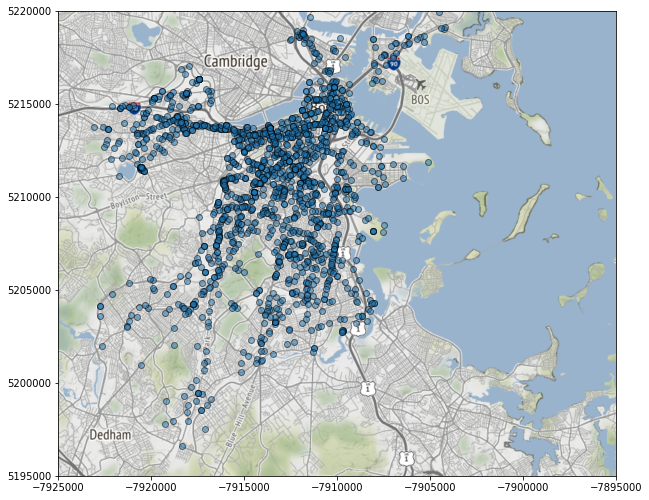

In [24]:
# Load the second crash dataset (2015-2018)
crash2 = pd.read_csv(data_path + 'crash_open_data.csv')
crash2 = crash2[crash2.mode_type == 'bike'] # keeping only the bike accidents
crash2.index = range(len(crash2.index))
# Converting into a geopandas. Note that coordinates are encoded in EPSG:3586 (Massachusetts)
# See https://epsg.io/3586
geocrash2 = gpd.GeoDataFrame(crash2.drop(['x_cord', 'y_cord', 'lat', 'long'], axis=1),
                             crs={'init': 'epsg:3586'},
                             geometry=[geometry.Point(xy) for xy in zip(crash2.x_cord, crash2.y_cord)])

feature_sel = [
    'dispatch_ts',
    'location_type',
    'geometry'
]
geocrash2 = geocrash2[feature_sel]

geocrash2['dispatch_ts'] = pd.to_datetime(geocrash2['dispatch_ts'])
geocrash2['DATE'] = geocrash2['dispatch_ts'].dt.date
geocrash2['YEAR'] = geocrash2['dispatch_ts'].dt.year
geocrash2['DAY_WEEK'] = geocrash2['dispatch_ts'].dt.day_name()
geocrash2['TIME'] = geocrash2['dispatch_ts'].dt.hour
geocrash2['ISINTERSEC'] = (geocrash2['location_type'] == 'Intersection').astype('int')
geocrash2 = geocrash2[['DATE', 'YEAR', 'DAY_WEEK', 'TIME', 'ISINTERSEC', 'geometry']]

geocrash2 = to_x_y(geocrash2)
plot_on_map(geocrash2)
geocrash2

Accident reports available: 3470


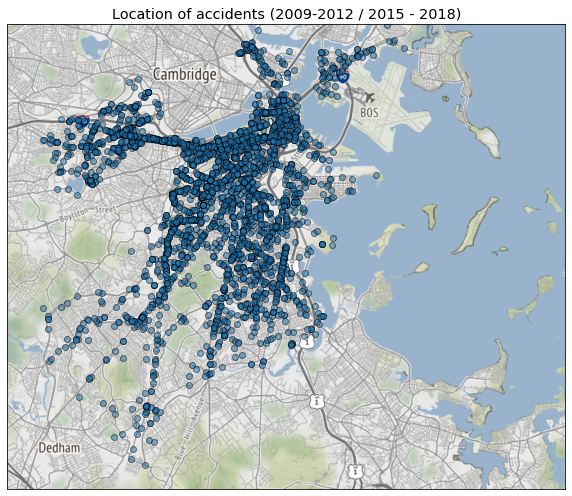

In [45]:
# Finally, create the merged crash dataset
geocrash = pd.concat([geocrash1,geocrash2])
geocrash.index = range(len(geocrash.index))
geocrash['MONTH'] = pd.to_datetime(geocrash['DATE']).dt.month
geocrash['WEEK'] = pd.to_datetime(geocrash['DATE']).dt.week
display(geocrash)
print(f'Accident reports available: {len(geocrash)}')

ax = plot_on_map(geocrash)
plt.title('Location of accidents (2009-2012 / 2015 - 2018)')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.get_figure().savefig("fig/accident_locations.png", bbox_inches='tight')

# Look at more visualization 
# https://residentmario.github.io/geoplot/examples/nyc-collision-factors.html
# https://residentmario.github.io/geoplot/examples/nyc-collisions-map.html

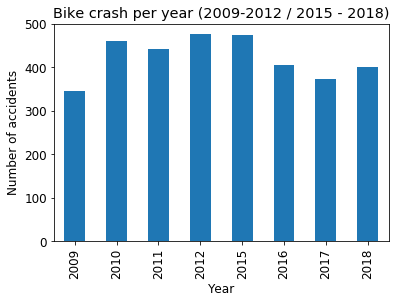

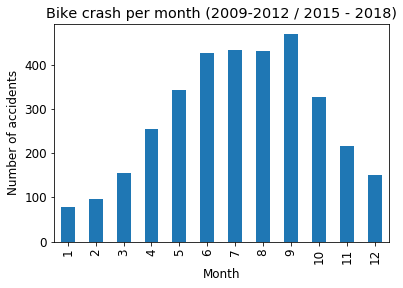

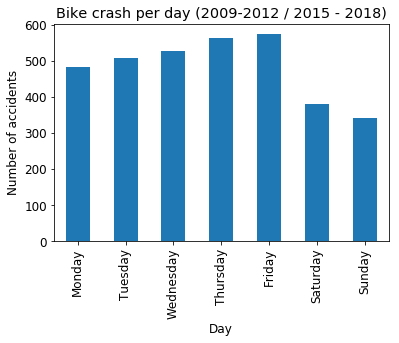

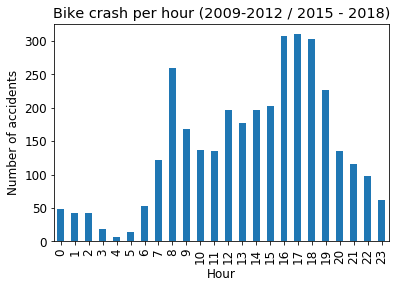

In [51]:
# A few plots of summary of accidents per year, month, ...
f = plt.figure()
geocrash['YEAR'].value_counts().sort_index().plot(kind='bar')
plt.title('Bike crash per year (2009-2012 / 2015 - 2018)')
plt.xlabel('Year')
plt.ylabel('Number of accidents')
f.savefig("fig/hist_bike_crash_year.png", bbox_inches='tight')

f = plt.figure()
geocrash['MONTH'].value_counts().sort_index().plot(kind='bar')
plt.title('Bike crash per month (2009-2012 / 2015 - 2018)')
plt.xlabel('Month')
plt.ylabel('Number of accidents')
f.savefig("fig/hist_bike_crash_month.png", bbox_inches='tight')

f = plt.figure()
geocrash['DAY_WEEK'] = pd.Categorical(geocrash['DAY_WEEK'], 
                                      categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], 
                                      ordered=True)
geocrash['DAY_WEEK'].value_counts().sort_index().plot(kind='bar')
plt.title('Bike crash per day (2009-2012 / 2015 - 2018)')
plt.xlabel('Day')
plt.ylabel('Number of accidents')
f.savefig("fig/hist_bike_crash_day.png", bbox_inches='tight')

f = plt.figure()
geocrash['TIME'].value_counts().sort_index().plot(kind='bar')
plt.title('Bike crash per hour (2009-2012 / 2015 - 2018)')
plt.xlabel('Hour')
plt.ylabel('Number of accidents')
f.savefig("fig/hist_bike_crash_hour.png", bbox_inches='tight')

In [47]:
# Match bike lanes with segments from masegs to merge info into masegs
# Notes:
# - one Rd_Seg_ID in geolanes can correspond to multiple ones in masegs
# - the reverse is also true
# - but some lanes don't have a Rd_Seg_ID number so we need to match them spatially (or add them to masegs)
# - in the end I chose to match only based on space, not using Rd_Seg_ID

# # Previous attempt a merging using the index for some of the bike lanes
# geolanes_noid = geolanes[geolanes['Rd_Seg_ID'].isnull()]
# geolanes_id = geolanes[~geolanes['Rd_Seg_ID'].isnull()]
# masegs2 = pd.merge(masegs[~masegs['Rd_Seg_ID'].isnull()], geolanes[['Rd_Seg_ID', 'ExisFacil', 'InstallDat']], on='Rd_Seg_ID')
# # only 83% of lanes in geolanes can be identified in masegs using Rd_Seg_ID:
# geolanes['Found'] = geolanes['Rd_Seg_ID'].apply(lambda x: (masegs['Rd_Seg_ID'] == x).any())
# print(geolanes['Found'].sum()/geolanes['Found'].count()) 

# Instead, build index to join bike lanes and street segments
geolanes['masegs_idx'] = geolanes.geometry.apply(find_nearest_seg, args=(masegs,50))
s = geolanes['masegs_idx'].isnull()
print(f'Unmatched bike lanes: {s.sum()}')

# check if masegs_idx are unique, if keep only the most recently installed bike lane
# that happens for a bunch of long segments (up to 12 bike lanes registered with the same segment)
geolanes = geolanes.sort_values('InstallDat').drop_duplicates(subset='masegs_idx', keep='last')

# add a field bikelane 0/1 or with the type and a field for the install date
idx = geolanes['masegs_idx'].astype('int')
masegs['ExisFacil'] = None
masegs.iloc[idx, masegs.columns == 'ExisFacil'] = geolanes['ExisFacil'].values
masegs['ExisFacil'] = masegs['ExisFacil'].astype('category')
masegs['InstallDat'] = None
masegs.iloc[idx, masegs.columns == 'InstallDat'] = geolanes['InstallDat'].values


Unmatched bike lanes: 0


Unmatched accidents: 91
Accident reports available: 3379


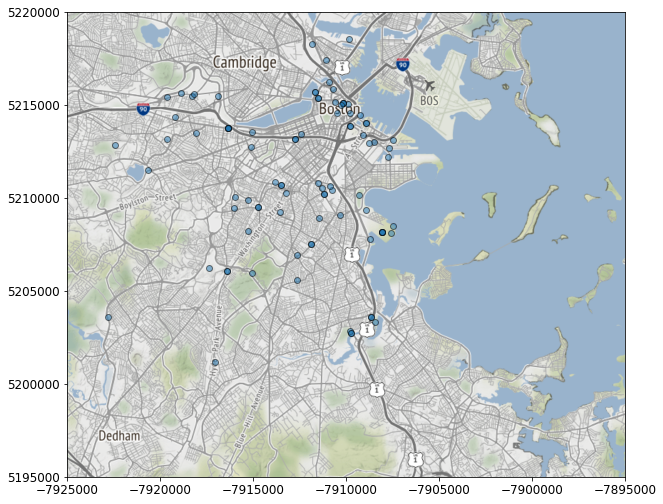

In [48]:
# Build index to join crashes and segment features
geocrash['masegs_idx'] = geocrash.geometry.apply(find_nearest_seg, args=(masegs,50))
# s = geocrash['masegs_idx'].isnull()
# geocrash.loc[s, 'masegs_idx'] = geocrash[s].geometry.apply(find_nearest_seg, args=(masegs,60))

# Info about the unmatched accident locations (> 50m from known streets)
s = geocrash['masegs_idx'].isnull()
print(f'Unmatched accidents: {s.sum()}')
plot_on_map(geocrash[s]);

# Dropping them
geocrash = geocrash[~s]
geocrash.index = range(len(geocrash.index))
print(f'Accident reports available: {len(geocrash)}')

In [49]:
# Now get the total number of accidents per segment
crash_count = geocrash['masegs_idx'].value_counts()
masegs['crash'] = 0
masegs.iloc[crash_count.index.astype(int), masegs.columns == 'crash'] = crash_count.values
masegs

# TODO: divide segments that have had a bike land installed into one segment without a BL and one with
# Then match the accidents with the segs without and with BL depending on accident date
# But we would need to account for the fact that after BL installation, no more accidents are possible 
# in the without BL segment (offset in model?)

# # Compute before and after dates
# idate = pd.to_datetime(masegs['InstallDat'], format='%Y')
# # can add a buffer period before/after installation
# # import dateutil.relativedelta
# # bdate = idate.apply(lambda d: d - dateutil.relativedelta.relativedelta(months=6))
# # adate = idate.apply(lambda d: d + dateutil.relativedelta.relativedelta(months=6))

# # Build the dataset
# def get_crash_num(seg_idx):
#     bitv = 1 + abs(idate[seg_idx].year - 2009) #nb of years between dataset start (2009) and idate
#     bnum = len(geocrash.query('masegs_idx == @seg_idx & DATE < @idate[@seg_idx]'))
#     aitv = 1 + abs(2018 - idate[seg_idx].year) #nb of years between dataset start (2018) and idate
#     anum = len(geocrash.query('masegs_idx == @seg_idx & DATE > @idate[@seg_idx]'))
#     return bnum, bitv, anum, aitv
    
# bnum = np.zeros(len(masegs))
# bitv = np.zeros(len(masegs))
# anum = np.zeros(len(masegs))
# aitv = np.zeros(len(masegs))
# for i in masegs.index:
#     bnum[i], bitv[i], anum[i], aitv[i] = get_crash_num(i)

# masegs['Before'] = pd.Series(bnum, index=geolanes.index)
# masegs['After'] = pd.Series(anum, index=geolanes.index)

OBJECTID Route_ID  Rd_Seg_ID              St_Name             Facility  \
0           856    B0240        NaN                 None  Bicycle/ Pedestrian   
1           858    B0240        NaN                 None  Bicycle/ Pedestrian   
2           860    B0240        NaN                 None  Bicycle/ Pedestrian   
3           882    B0246        NaN                 None  Bicycle/ Pedestrian   
4           883    B0247        NaN                 None  Bicycle/ Pedestrian   
5           884    B0247        NaN                 None  Bicycle/ Pedestrian   
6           885    B0247        NaN                 None  Bicycle/ Pedestrian   
7           886    B0248        NaN                 None  Bicycle/ Pedestrian   
8           887    B0248        NaN                 None  Bicycle/ Pedestrian   
9           888    B0248        NaN                 None  Bicycle/ Pedestrian   
10          890    B0248        NaN                 None  Bicycle/ Pedestrian   
11          891    B0249        NaN                 None  Bicycle/ Pedestrian   
12         1019    B0283        NaN                 None  Bicycle/ Pedestrian   
13         1020    B0283        NaN                 None  Bicycle/ Pedestrian   
14         1021    B0283        NaN                 None  Bicycle/ Pedestrian   
15         1022    B0283        NaN                 None  Bicycle/ Pedestrian   
16         1023    B0283        NaN                 None  Bicycle/ Pedestrian   
17         1024    B0283        NaN                 None  Bicycle/ Pedestrian   
18         1025    B0283        NaN                 None  Bicycle/ Pedestrian   
19         1027    B0283        NaN                 None  Bicycle/ Pedestrian   
20         1028    B0283        NaN                 None  Bicycle/ Pedestrian   
21         1029    B0283        NaN                 None  Bicycle/ Pedestrian   
22         1030    B0283        NaN                 None  Bicycle/ Pedestrian   
23         1031    B0283        NaN                 None  Bicycle/ Pedestrian   
24         1032    B0283        NaN                 None  Bicycle/ Pedestrian   
25         1033    B0283        NaN                 None  Bicycle/ Pedestrian   
26         1035    B0283        NaN                 None  Bicycle/ Pedestrian   
27         1037    B0283        NaN                 None  Bicycle/ Pedestrian   
28         1039    B0283        NaN                 None  Bicycle/ Pedestrian   
29         1041    B0283        NaN                 None  Bicycle/ Pedestrian   
...         ...      ...        ...                  ...                  ...   
29136    621269  US20 WB   477153.0  NORTH BEACON STREET     Mainline roadway   
29137    621270  US20 WB   477153.0  NORTH BEACON STREET     Mainline roadway   
29138    621271  US20 WB   477153.0  NORTH BEACON STREET     Mainline roadway   
29139    621272  US20 WB    62346.0  NORTH BEACON STREET     Mainline roadway   
29140    621273  US20 WB    62381.0  NORTH BEACON STREET     Mainline roadway   
29141    621274  US20 WB    62381.0  NORTH BEACON STREET     Mainline roadway   
29142    621275  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29143    621276  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29144    621277  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29145    621278  US20 WB    62382.0  NORTH BEACON STREET     Mainline roadway   
29146    621279  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29147    621280  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29148    621281  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29149    621282  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29150    621283  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29151    621284  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29152    621285  US20 WB    62831.0  NORTH BEACON STREET     Mainline roadway   
29153    621286  US20 WB    62448.0  N

In [141]:
# Saving session at that point
dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

# Also pickling for the other notebook
data = {'masegs': masegs, 'geolanes': geolanes, 'geocrash': geocrash}
with open('eda_output.dat', 'wb') as f:
    pickle.dump(data, f)

Overdispersion check: mean 0.12, var 0.29
Most dangerous segment:


OBJECTID                                                    576599
Route_ID                                                   SR2A EB
Rd_Seg_ID                                                    45037
St_Name                                       MASSACHUSETTS AVENUE
Facility                                          Mainline roadway
F_F_Class                               Principal Arterial - Other
Num_Lanes                                                        4
Lt_Sidewlk                                                      15
Rt_Sidewlk                                                      15
Operation                                          Two-way traffic
Speed_Lim                                                       30
Struct_Cnd                                                    Good
AADT                                                         28381
Length                                                   0.0452639
ShapeSTLength                                              72.

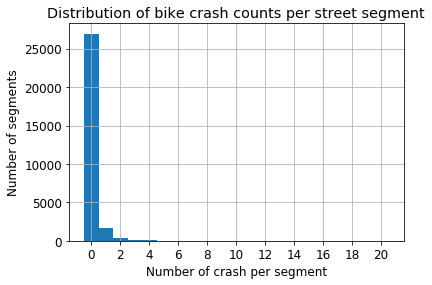

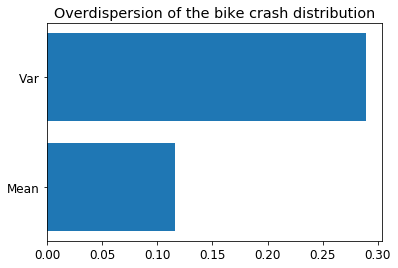

In [91]:
f = plt.figure()
masegs['crash'].hist(bins=np.arange(-0.5,21))
plt.title('Distribution of bike crash counts per street segment')
plt.xlabel('Number of crash per segment')
plt.ylabel('Number of segments')
plt.xticks(range(0,21,2))
f.savefig("fig/hist_bike_crash_segments.png", bbox_inches='tight')

f = plt.figure()
plt.barh([1, 2],[masegs['crash'].mean(), masegs['crash'].var()])
plt.title('Overdispersion of the bike crash distribution')
plt.yticks(range(1,3), ['Mean', 'Var'])
f.savefig("fig/overdispersion.png", bbox_inches='tight')
print(f"Overdispersion check: mean {masegs['crash'].mean():.2f}, var {masegs['crash'].var():.2f}")
      
print('Most dangerous segment:')
display(masegs.iloc[masegs['crash'].idxmax()])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


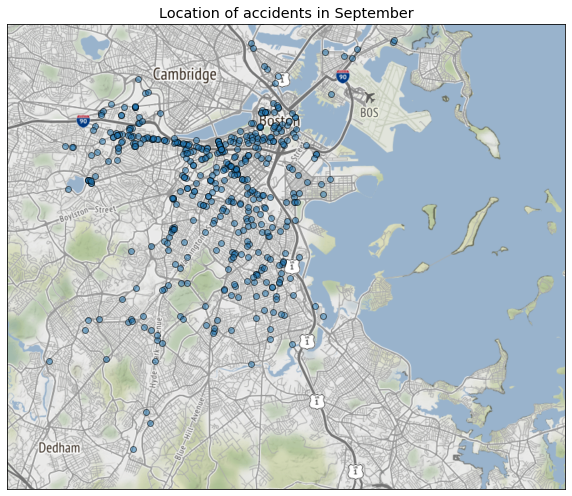

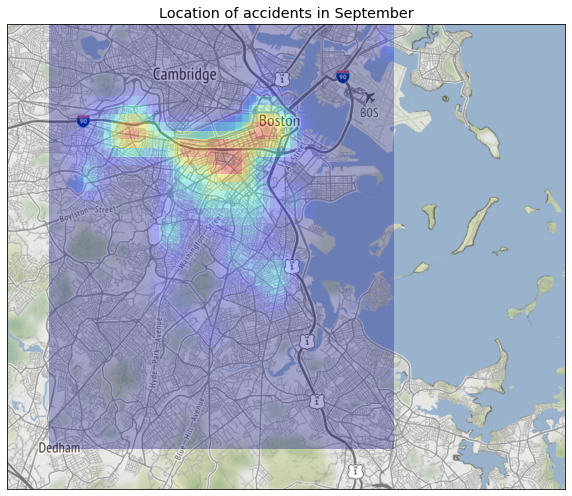

In [130]:
# Try to do spatio-temporal plots like the accident map for a given month or day or hour
# Could potentially output those results to app to have more real-time prediction

ax = plot_on_map(geocrash[geocrash.MONTH == 9])
plt.title('Location of accidents in September')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# ax = plot_on_map(geocrash[geocrash.DAY_WEEK == 'Friday'])
# plt.title('Location of accidents on Friday')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

# Maybe use a heatmap with kde
# import geoplot.crs as gcrs
# import geoplot as gplt
# gplt.kdeplot(collisions[collisions["CONTRIBUTING FACTOR VEHICLE 1"] == 'Failure to Yield Right-of-Way'],
#              projection=gcrs.AlbersEqualArea(), shade=True, clip=boroughs.geometry, shade_lowest=False, ax=ax1)

from scipy import ndimage
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = heatmap
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent, alpha=0.3)
#     plt.colorbar()
    plt.show()

f = plt.figure(figsize=(10, 10))
plt.title('Location of accidents in September')
ax = plt.gca()
add_basemap(ax, zoom=12)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
heatmap(geocrash[geocrash.MONTH == 9].geometry, bins=50, smoothing=1.5)

